# Deep Learning Basics with PyTorch
## Part II — Neural Networks and PyTorch Basics
## Chapter 6 — Building Neurons and Activations

In [1]:
 # !pip -q install torch numpy matplotlib scikit-learn
import torch, numpy as np, matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8')  # plotting
%config InlineBackend.figure_format = 'retina'


## Activation functions

In [2]:
x = torch.linspace(-4, 4, steps = 9)
torch.sigmoid(x), torch.tanh(x), torch.relu(x)


(tensor([0.0180, 0.0474, 0.1192, 0.2689, 0.5000, 0.7311, 0.8808, 0.9526, 0.9820]),
 tensor([-0.9993, -0.9951, -0.9640, -0.7616,  0.0000,  0.7616,  0.9640,  0.9951,
          0.9993]),
 tensor([0., 0., 0., 0., 0., 1., 2., 3., 4.]))

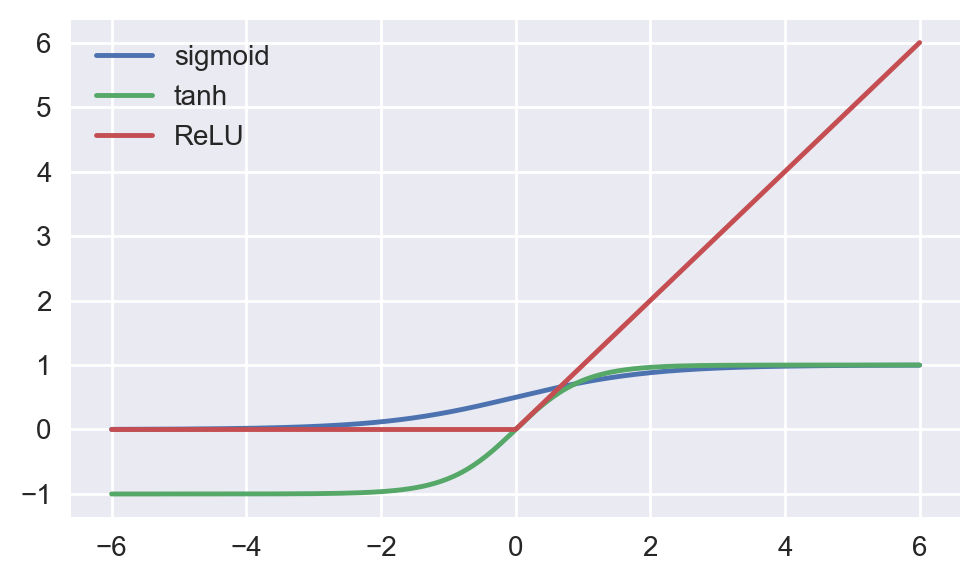

In [3]:
x = np.linspace(-6, 6, 400)
plt.figure(figsize = (5, 3))  # plotting
plt.plot(x, 1/(1+np.exp(-x)), label = 'sigmoid')
plt.plot(x, np.tanh(x), label = 'tanh')
plt.plot(x, np.maximum(0, x), label = 'ReLU')
plt.legend(frameon = False)
plt.tight_layout()
plt.show()


## Manual forward for a 2-layer MLP

In [4]:
torch.manual_seed(0)  # reproducibility
x = torch.randn(5, 2)
W1 = torch.randn(2, 4)  # layer 1 weights
b1 = torch.randn(4)  # layer 1 bias
W2 = torch.randn(4, 1)  # layer 2 weights
b2 = torch.randn(1)  # layer 2 bias
h = torch.relu(x @ W1 + b1)  # hidden activations
y = h @ W2 + b2  # targets/labels
y.shape

torch.Size([5, 1])

## XOR decision boundary: linear vs 2-layer MLP (quick demo)

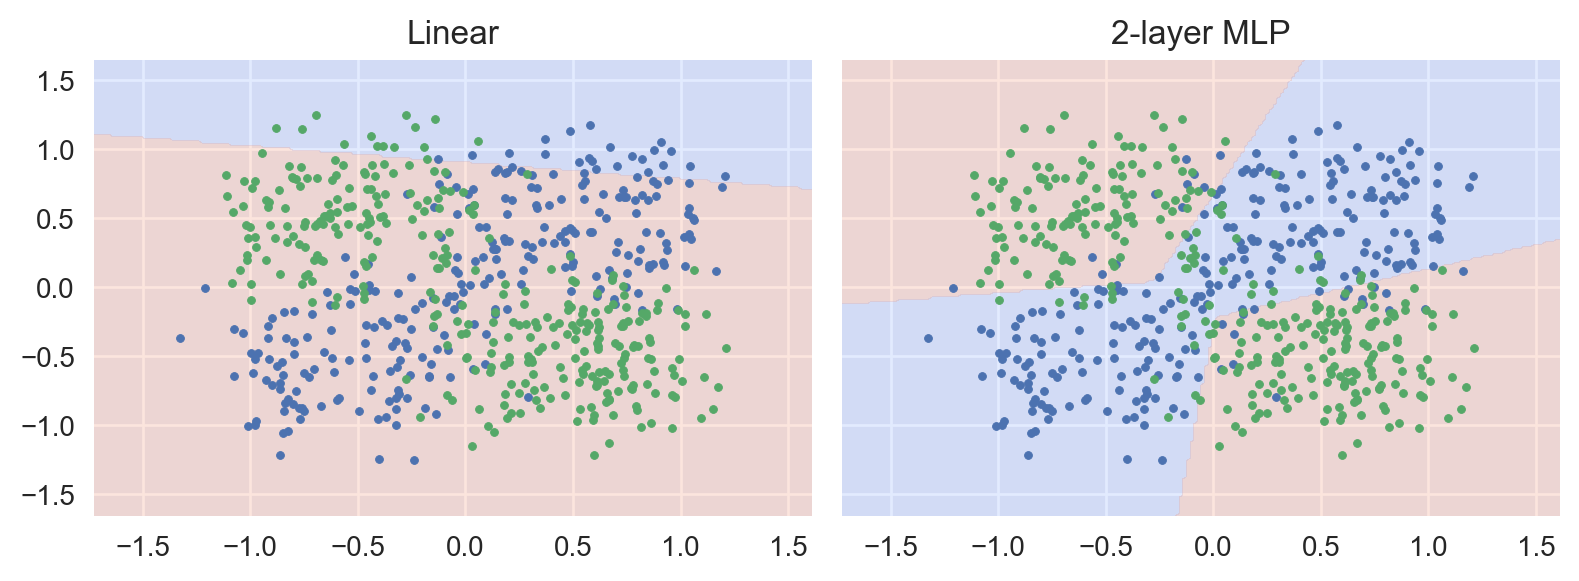

In [5]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression

# RNG setup and data generation
rng = np.random.default_rng(0)
X = rng.uniform(-1, 1, size=(600, 2))  # inputs
y = ((X[:, 0] > 0) ^ (X[:, 1] > 0)).astype(int)  # XOR-like targets
X = X + rng.normal(0, 0.15, size=X.shape)  # add noise

# Baseline linear classifier
lin = LogisticRegression().fit(X, y)

# Two-layer MLP parameters
W1 = torch.randn(2, 8, requires_grad=True)
b1 = torch.zeros(8, requires_grad=True)
W2 = torch.randn(8, 2, requires_grad=True)
b2 = torch.zeros(2, requires_grad=True)

# Light init scaling without tracking gradients
with torch.no_grad():
    W1.mul_(0.5)
    W2.mul_(0.5)

# Numpy -> Torch tensors
X_t = torch.tensor(X, dtype=torch.float32)
y_t = torch.tensor(y, dtype=torch.long)

# Simple SGD loop
for _ in range(1500):
    h = torch.relu(X_t @ W1 + b1)  # hidden activations
    logits = h @ W2 + b2
    loss = torch.nn.functional.cross_entropy(logits, y_t)

    # Zero grads, backprop, and parameter update
    for p in (W1, b1, W2, b2):
        if p.grad is not None:
            p.grad.zero_()

    loss.backward()

    with torch.no_grad():
        for p in (W1, b1, W2, b2):
            p -= 0.1 * p.grad

# Plot decision regions after training
xmin, xmax = X[:, 0].min() - 0.4, X[:, 0].max() + 0.4
ymin, ymax = X[:, 1].min() - 0.4, X[:, 1].max() + 0.4
xx, yy = np.meshgrid(
    np.linspace(xmin, xmax, 200), np.linspace(ymin, ymax, 200)
)
grid = np.c_[xx.ravel(), yy.ravel()]

with torch.no_grad():
    h = torch.relu(torch.tensor(grid, dtype=torch.float32) @ W1 + b1)
    zz_mlp = (h @ W2 + b2).argmax(dim=1).numpy().reshape(xx.shape)
    zz_lin = lin.predict(grid).reshape(xx.shape)

fig, ax = plt.subplots(1, 2, figsize=(8, 3), sharex=True, sharey=True)
for a, zz, title in zip(ax, [zz_lin, zz_mlp], ['Linear', '2-layer MLP']):
    a.contourf(xx, yy, zz, levels=[-0.5, 0.5, 1.5], cmap='coolwarm', alpha=0.25)
    a.scatter(X[y == 0, 0], X[y == 0, 1], s=8)
    a.scatter(X[y == 1, 0], X[y == 1, 1], s=8)
    a.set_title(title)

plt.tight_layout()
plt.show()
